# Audio Feature Extraction & Analysis

The aim of this project is the discover what combination of audio features gives the best performance with electronic versus organic source classification. Source recognition is treated as a binary classification problem, with a sound represented as either orginating from a live in-person source or an electronic source. Features extracted by [Essentia](http://essentia.upf.edu/) and [LibROSA](https://librosa.github.io/librosa/), tools for audio analysis and audio-based music information retrieval, were used.

**Next steps:** 
- examine the influence of various feature sets (e.g., low level, tonal, high-level, and their combination) on improving source recognition
- improve feature parsing methods for essentia + libROSA + other libraries
- develop a comprehensive feature set to characterize each audio file

In [285]:
%matplotlib inline  
import essentia
from essentia.standard import *
import essentia.standard as es
from os import listdir
from os.path import isfile, join, basename, splitext
import librosa
import librosa.display
import IPython
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("bright")

In [160]:
valid_exts = ['.mp3', '.wav', '.flac']
dir_electronic = 'audio/Electronic/'
dir_organic = 'audio/Organic/'

# extract electronic file paths
electronic_files = [dir_electronic + x for x in 
   [f for f in listdir(dir_electronic) if (isfile(join(dir_electronic, f)) # get files only
   and bool([ele for ele in valid_exts if(ele in f)])) ]                   # get audio files only
  ]  

# extract organic file paths
organic_files = [dir_organic + x for x in 
   [f for f in listdir(dir_organic) if (isfile(join(dir_organic, f))       # get files only
   and bool([ele for ele in valid_exts if(ele in f)])) ]                   # get audio files only
  ] 

## Parsing in Essentia

In [161]:
# TBD - there are a lot of features extracted here - which should we keep & which are missing?
print(organic_files)
print(splitext(basename(audio_files[0]))[0])
features, features_frames = es.MusicExtractor(
    lowlevelStats=['mean', 'stdev'], 
    rhythmStats=['mean', 'stdev'], 
    tonalStats=['mean', 'stdev'])(organic_files[0])
print("\nFEATURES count =", len(features.descriptorNames()))
YamlOutput(filename = 'output/'+ splitext(basename(audio_files[0]))[0] + '_features.sig')(features)

['audio/Organic/close_test.wav', 'audio/Organic/open_test.wav', 'audio/Organic/alexa_test.wav', 'audio/Organic/hello_google_test.wav', 'audio/Organic/stop_test.wav', 'audio/Organic/shop_test.wav']
musicbox

FEATURES count = 161


## Parsing in LibROSA

In [172]:
def create_chroma_df(chroma):
    chroma_mean = np.mean(chroma, axis = 1)
    chroma_std = np.std(chroma, axis = 1)
    
    chroma_df = pd.DataFrame()
    for i in range(0,12):
        chroma_df['chroma ' + str(i) + ' mean'] = chroma_mean[i]
        chroma_df['chroma ' + str(i) + ' std'] = chroma_std[i]
    chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis = 0)

    return chroma_df

In [173]:
def create_mfccs_df(mfccs):
    mfccs_mean = np.mean(mfccs, axis = 1)
    mfccs_std = np.std(mfccs, axis = 1)
   
    mfccs_df = pd.DataFrame()
    for i in range(0,13):
        mfccs_df['mfccs ' + str(i) + ' mean'] = mfccs_mean[i]
        mfccs_df['mfccs ' + str(i) + ' std'] = mfccs_std[i]
    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis = 0)
    
    return mfccs_df

In [174]:
def create_spectral_df(cent, contrast, rolloff):
    
    # spectral centroids values
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis = 1)[0]

    # spectral contrasts values
    contrast_mean = np.mean(contrast, axis = 1)
    contrast_std = np.std(contrast, axis = 1)
    
    # spectral rolloff points values
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff, axis = 1)[0]

    spectral_df = pd.DataFrame()
    collist = ['cent mean','cent std','cent skew',
               'rolloff mean', 'rolloff std', 'rolloff skew']
    for i in range(0,7):
        collist.append('contrast ' + str(i) + ' mean')
        collist.append('contrast ' + str(i) + ' std')
    
    for c in collist:
        spectral_df[c] = 0
    data = np.concatenate((
        [cent_mean, cent_std, cent_skew], 
        [rolloff_mean, rolloff_std, rolloff_skew], 
        contrast_mean, contrast_std),
        axis = 0)
    spectral_df.loc[0] = data
    
    return spectral_df

In [175]:
def create_zrate_df(zrate):
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate, axis = 1)[0]

    zrate_df = pd.DataFrame()
    zrate_df['zrate mean'] = 0
    zrate_df['zrate std'] = 0
    zrate_df['zrate skew'] = 0
    zrate_df.loc[0]=[zrate_mean, zrate_std, zrate_skew]
    
    return zrate_df

In [176]:
def create_beat_df(tempo):
    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo
    return beat_df

In [177]:
def extract_features(audio, target = 0): # if no classification given, assume electronic
    y, sr = librosa.load(audio)
    
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    beat_time_diff = np.ediff1d(beat_times)
    beat_nums = np.arange(1, np.size(beat_times))
    
    chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    
    mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    
    contrast = librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
    
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    
    chroma_df = create_chroma_df(chroma)
    
    mfccs_df = create_mfccs_df(mfccs)
    
    spectral_df = create_spectral_df(cent, contrast, rolloff)
    
    zrate_df = create_zrate_df(zrate)
    
    beat_df = create_beat_df(tempo)
    
    id_df = pd.DataFrame({'id' : [audio.split('/')[-1].split('.')[0]]})
    
    target_df = pd.DataFrame({'target' : [target]})
    
    final_df = pd.concat((id_df, chroma_df, mfccs_df, spectral_df, zrate_df, beat_df, target_df), axis = 1)
    
    return final_df

In [178]:
all_audio = []

print('\nReading ELECTRONIC directory ...')
for electronic_file in electronic_files:
    audio_features = extract_features(electronic_file, 0)
    all_audio.append(audio_features)
    print('\tCompleted feature extraction for', electronic_file)

print('\nReading ORGANIC directory ...')
for organic_file in organic_files:
    audio_features = extract_features(organic_file, 1)
    all_audio.append(audio_features)
    print('\tCompleted feature extraction for', organic_file)

print('\nPutting it altogether ...')
df_audio = pd.concat(all_audio)
# df_audio.set_index(audio['id'], inplace = True)
df_audio.to_csv('librosa_features.csv', index = True)
print('\nDONE.')


Reading ELECTRONIC directory ...
	Completed feature extraction for audio/Electronic/shopElecD.wav
	Completed feature extraction for audio/Electronic/musicbox.wav
	Completed feature extraction for audio/Electronic/stopElecD.wav


/usr/local/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


	Completed feature extraction for audio/Electronic/human_rights.mp3
	Completed feature extraction for audio/Electronic/closeElecD.wav
	Completed feature extraction for audio/Electronic/hello_google_ElecD.wav
	Completed feature extraction for audio/Electronic/openElecD.wav

Reading ORGANIC directory ...
	Completed feature extraction for audio/Organic/close_test.wav
	Completed feature extraction for audio/Organic/open_test.wav
	Completed feature extraction for audio/Organic/alexa_test.wav
	Completed feature extraction for audio/Organic/hello_google_test.wav
	Completed feature extraction for audio/Organic/stop_test.wav
	Completed feature extraction for audio/Organic/shop_test.wav

Putting it altogether ...

DONE.


## Understanding the Dataset

In [179]:
print(df_audio.target)

0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    1
0    1
0    1
0    1
0    1
0    1
Name: target, dtype: int64


In [181]:
print(df_audio.shape)      # output: (n_samples, n_features)
print(df_audio.keys())     # available data attributes
print(df_audio[0:3])       # show example data rows

(13, 76)
Index(['id', 'chroma 0 mean', 'chroma 0 std', 'chroma 1 mean', 'chroma 1 std',
       'chroma 2 mean', 'chroma 2 std', 'chroma 3 mean', 'chroma 3 std',
       'chroma 4 mean', 'chroma 4 std', 'chroma 5 mean', 'chroma 5 std',
       'chroma 6 mean', 'chroma 6 std', 'chroma 7 mean', 'chroma 7 std',
       'chroma 8 mean', 'chroma 8 std', 'chroma 9 mean', 'chroma 9 std',
       'chroma 10 mean', 'chroma 10 std', 'chroma 11 mean', 'chroma 11 std',
       'mfccs 0 mean', 'mfccs 0 std', 'mfccs 1 mean', 'mfccs 1 std',
       'mfccs 2 mean', 'mfccs 2 std', 'mfccs 3 mean', 'mfccs 3 std',
       'mfccs 4 mean', 'mfccs 4 std', 'mfccs 5 mean', 'mfccs 5 std',
       'mfccs 6 mean', 'mfccs 6 std', 'mfccs 7 mean', 'mfccs 7 std',
       'mfccs 8 mean', 'mfccs 8 std', 'mfccs 9 mean', 'mfccs 9 std',
       'mfccs 10 mean', 'mfccs 10 std', 'mfccs 11 mean', 'mfccs 11 std',
       'mfccs 12 mean', 'mfccs 12 std', 'cent mean', 'cent std', 'cent skew',
       'rolloff mean', 'rolloff std', 'rolloff 

## Data Visualization

In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [183]:
df_audio.head()

,id,chroma 0 mean,chroma 0 std,chroma 1 mean,chroma 1 std,chroma 2 mean,chroma 2 std,chroma 3 mean,chroma 3 std,chroma 4 mean,...,contrast 4 std,contrast 5 mean,contrast 5 std,contrast 6 mean,contrast 6 std,zrate mean,zrate std,zrate skew,tempo,target
0,shopElecD,0.211217,0.242185,0.297875,0.380819,0.317963,0.308470,0.251580,0.292419,0.279830,...,4.584441,6.141963,14.428967,4.427019,2.462031,0.121362,0.070151,0.863915,80.749512,0
0,musicbox,0.268751,0.374286,0.241735,0.307941,0.387346,0.292233,0.224029,0.182735,0.201479,...,4.486529,5.212562,7.431650,5.772303,3.672038,0.037200,0.011046,1.091982,161.499023,0
0,stopElecD,0.256668,0.257231,0.345864,0.319716,0.189388,0.224801,0.190445,0.190758,0.245685,...,7.867924,5.203124,3.829873,4.680789,2.561615,0.066943,0.015284,-0.699556,151.999081,0
0,human_rights,0.246127,0.225619,0.210824,0.220938,0.255757,0.273708,0.277858,0.297458,0.295570,...,7.939223,8.217205,5.846368,7.801807,10.311291,0.086084,0.044655,0.582687,123.046875,0
0,closeElecD,0.269616,0.217564,0.247631,0.250100,0.207491,0.193002,0.219317,0.280212,0.332068,...,8.628858,4.949891,7.984276,4.425116,2.180227,0.065654,0.018811,0.405056,0.000000,0


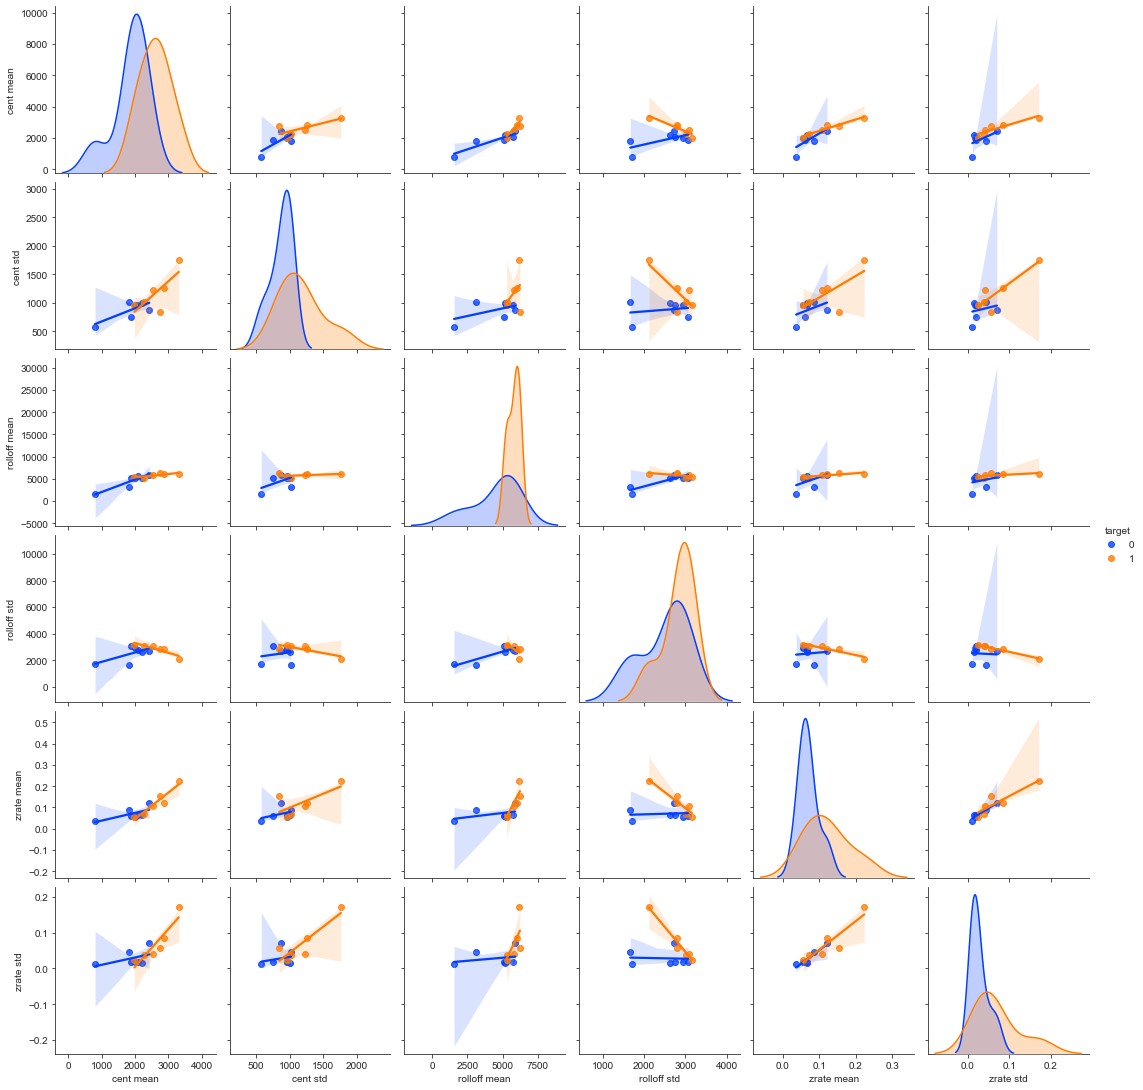

In [288]:
sns.pairplot(
    df_audio, 
    hue="target", 
    vars=['cent mean', 'cent std', 'rolloff mean', 'rolloff std', 'zrate mean', 'zrate std'],
    kind="reg"
)

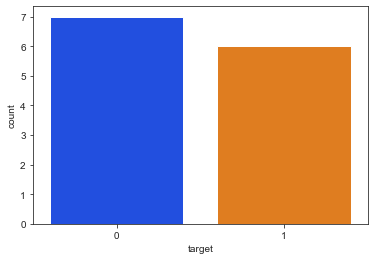

In [289]:
sns.countplot(df_audio['target'], label="Count")

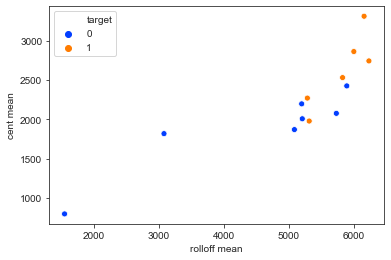

In [238]:
sns.scatterplot(x = 'rolloff mean', y = 'cent mean', hue = 'target', data = df_audio)

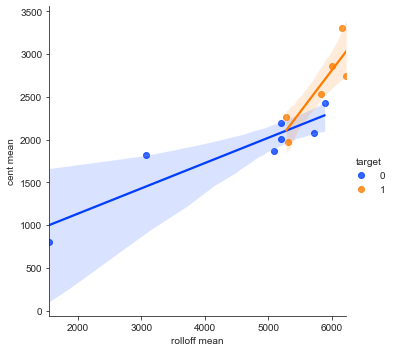

In [239]:
sns.lmplot('rolloff mean', 'cent mean', hue ='target', data = df_audio, fit_reg=True)

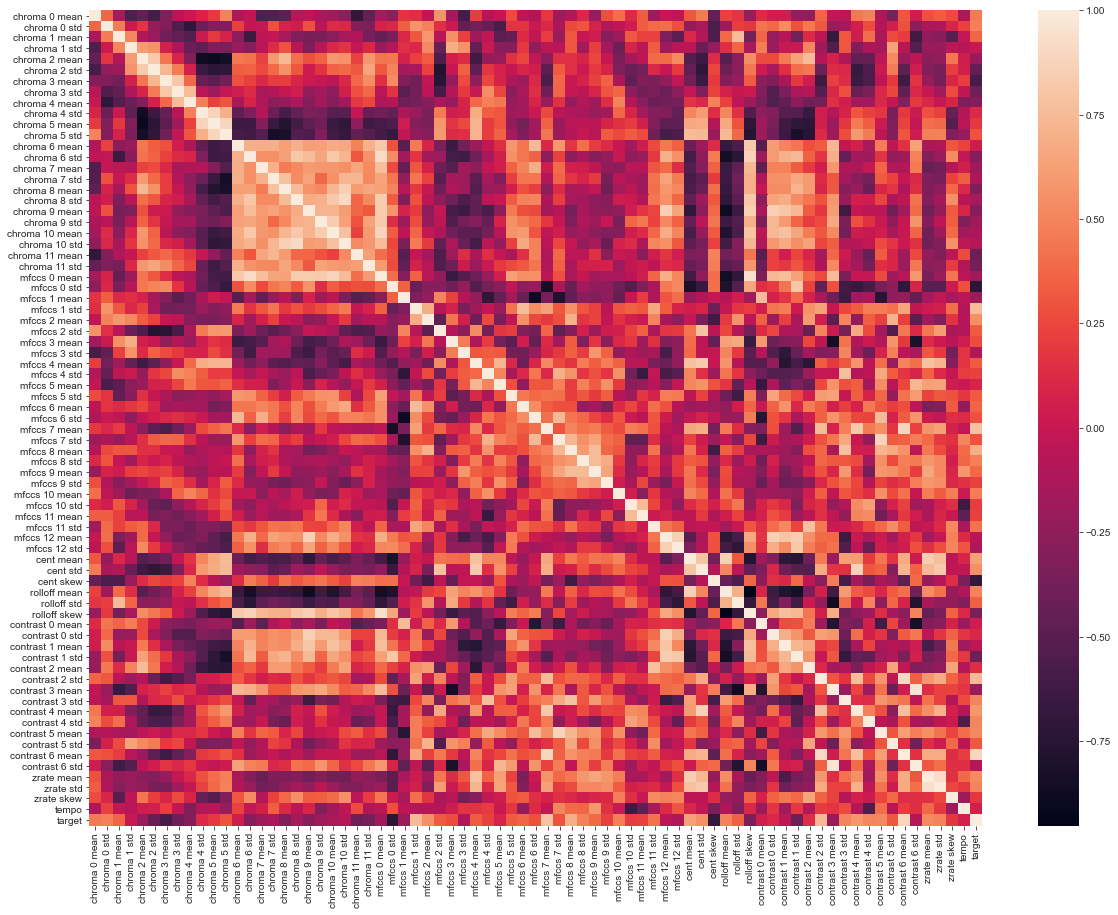

In [290]:
plt.figure(figsize=(20,15)) 
sns.heatmap(df_audio.corr(), annot=False) 

              precision    recall  f1-score   support

           0       0.29      1.00      0.44         2
           1       0.00      0.00      0.00         5

    accuracy                           0.29         7
   macro avg       0.14      0.50      0.22         7
weighted avg       0.08      0.29      0.13         7



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


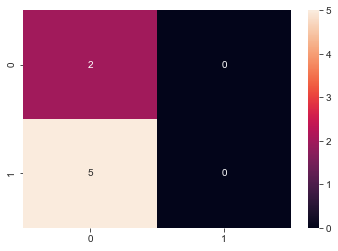

In [291]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
    df_audio.drop(['target', 'id'], axis=1),         # feature values per sample
    df_audio['target'],       # target labels per sample
    test_size=0.5,            # 50% test/ 50% training; proportion of the dataset to include in the test split
    random_state=109          # controls the shuffling applied to the data before applying split
)

classifier = svm.SVC(kernel='linear') # create a SVM classifier with a linear kernel
classifier.fit(X_train, y_train)      # train model using the training sets
y_pred = classifier.predict(X_test)   # predict the response for test dataset

confusion = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True)

print(metrics.classification_report(y_test, y_pred))

## Other ML

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

In [297]:
h = 0.02 # step size in the mesh
names = [
    'Nearest Neighbors', 
    'Linear SVM', 
    'RBF SVM', 
    'Gaussian Process', 
    'Decision Tree', 
    'Random Forest', 
    'Neural Net', 
    'Adaboot', 
    'Naive Bayes', 
    'QDA'
]
classifiers = [
    KNeighborsClassifier(3),       # number of neighbors = 3
    SVC(kernel='linear', C=0.025), # linear kernel with regularization/misclassification error = 0.025
    SVC(gamma=2, C=1),             # looser SVM with higher regularization
    GaussianProcessClassifier(1.0 * RBF(1.0)), # RBF kernel
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), # estimators = # of trees in the forest, max_features = # of features to consider when looking for best split
    MLPClassifier(alpha=1, max_iter=1000), # multilayer perceptron with L2 penalty/regularization = 1, max_iter = limit as solver iterates until convergence
    AdaBoostClassifier(), 
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

KeyboardInterrupt: 

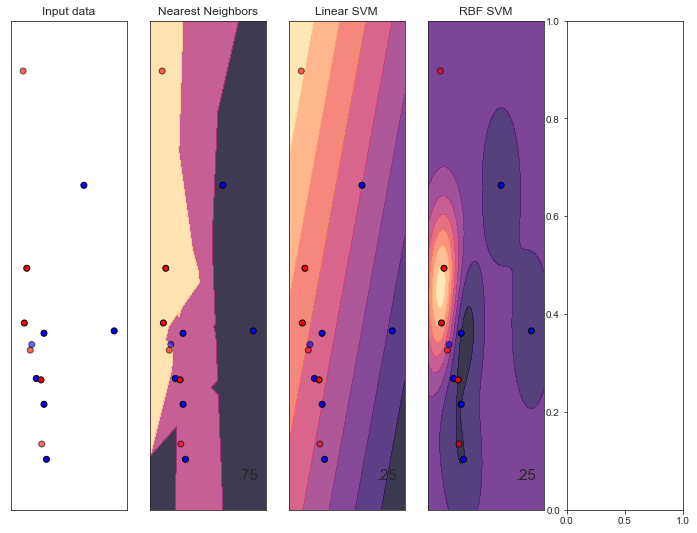

In [298]:
pca = PCA(n_components=2,svd_solver='full')

X = df_audio.drop(['target', 'id'], axis = 1).values
X = pca.fit_transform(X)
y = df_audio['target']

rng = np.random.RandomState(2)
datasets = [df_audio]

figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    #X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.magma
    cm_bright = ListedColormap(['blue', 'red'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [233]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_audio.drop(['target', 'id'], axis = 1).values
Y = df_audio['target']

X = StandardScaler().fit_transform(X)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

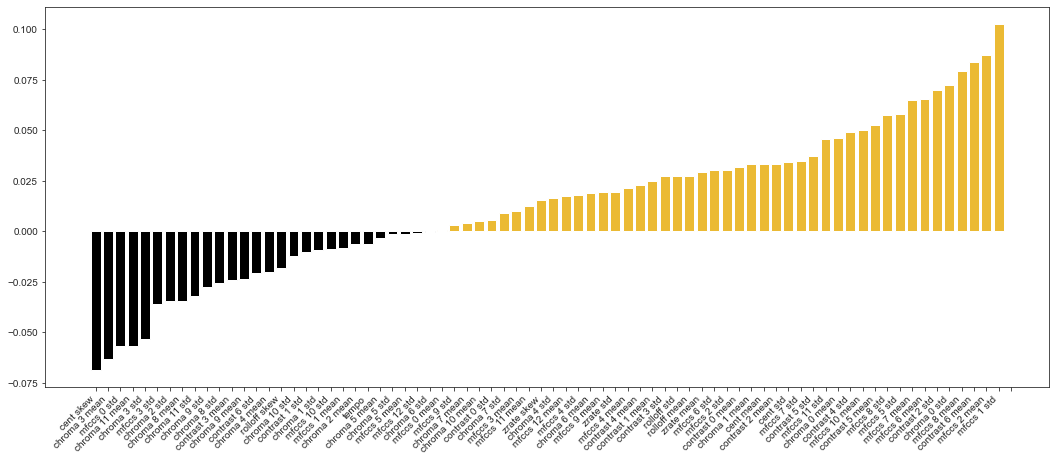

In [235]:
from sklearn import svm
import matplotlib.pyplot as plt

def feature_plot(classifier, feature_names, top_features=4):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(18, 7))
    colors = ['#000000' if c < 0 else '#ebba34' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
    plt.show()

trainedsvm = svm.LinearSVC().fit(X, Y)
feature_plot(
    trainedsvm,
    df_audio.drop(['target', 'id'], axis = 1).columns.values, 
    int(len(df_audio.drop(['target', 'id'], axis = 1).columns.values) / 2)
)

In [274]:
# Preprocessing :
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Logistic Regression

In [243]:
trainedmodel = LogisticRegression().fit(X_Train,Y_Train)
predictions = trainedmodel.predict(X_Test)
print(confusion_matrix(Y_Test,predictions))
print(classification_report(Y_Test,predictions))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### Random Forest

In [244]:
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)
predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### SVMs

In [245]:
trainedsvm = svm.LinearSVC().fit(X_Train, Y_Train)
predictionsvm = trainedsvm.predict(X_Test)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### Decision Tree

In [246]:
trainedtree = tree.DecisionTreeClassifier().fit(X_Train, Y_Train)
predictionstree = trainedtree.predict(X_Test)
print(confusion_matrix(Y_Test,predictionstree))
print(classification_report(Y_Test,predictionstree))

[[2 0]
 [1 1]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



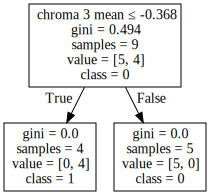

In [247]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

data = export_graphviz(
    trainedtree,out_file = None,
    feature_names = df_audio.drop(['target', 'id'], axis = 1).columns,
    class_names = ['0', '1'], 
    max_depth = 2,
    special_characters = True
)
graph = graphviz.Source(data)
graph

### Linear Discriminant Analysis

In [248]:
trainedlda = LinearDiscriminantAnalysis().fit(X_Train, Y_Train)
predictionlda = trainedlda.predict(X_Test)
print(confusion_matrix(Y_Test,predictionlda))
print(classification_report(Y_Test,predictionlda))

[[1 1]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



### Naive Bayes

In [249]:
trainednb = GaussianNB().fit(X_Train, Y_Train)
predictionnb = trainednb.predict(X_Test)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

[[2 0]
 [1 1]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



### XGBoost

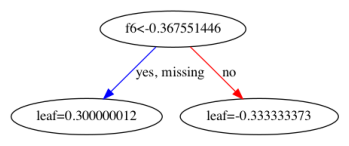

<Figure size 3600x3600 with 0 Axes>

In [250]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
model = XGBClassifier()

# Train
model.fit(X_Train, Y_Train)

plot_tree(model)
plt.figure(figsize = (50,50))
plt.show()

[[2 0]
 [1 1]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



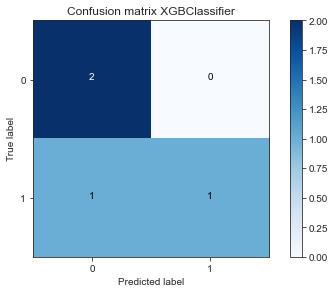

In [271]:
from itertools import product
import itertools

predictions = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictions))
print(classification_report(Y_Test,predictions))

# Thanks to: https://www.kaggle.com/tejainece/data-visualization-and-machine-learning-algorithms
def plot_confusion_matrix(cm, classes=["0", "1"], title="",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot = confusion_matrix(Y_Test,predictions)

plt.figure()
plot_confusion_matrix(cm_plot, title = 'XGBClassifier')

## Feature Engineering

In [275]:
pca = PCA(n_components=2,svd_solver='full')
X_pca = pca.fit_transform(X)
# print(pca.explained_variance_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(X_pca, Y, test_size = 0.30, random_state = 101)

# pca = PCA(n_components=2,svd_solver='full')
# X_reduced = pca.fit_transform(X_Train)
# X_reduced = TSNE(n_components=2).fit_transform(X_Train, Y_Train)

trainednb = GaussianNB().fit(X_reduced, Y_Train)
trainedsvm = svm.LinearSVC().fit(X_reduced, Y_Train)
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_reduced,Y_Train)
trainedmodel = LogisticRegression().fit(X_reduced,Y_Train)

# pca = PCA(n_components=2,svd_solver='full')
# X_test_reduced = pca.fit_transform(X_Test)
# X_test_reduced = TSNE(n_components=2).fit_transform(X_Test, Y_Test)

print('Naive Bayes')
predictionnb = trainednb.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

print('SVM')
predictionsvm = trainedsvm.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

print('Random Forest')
predictionforest = trainedforest.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

print('Logistic Regression')
predictions =trainedmodel.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictions))
print(classification_report(Y_Test,predictions))

Naive Bayes
[[1 1]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

SVM
[[1 1]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

Random Forest
[[1 1]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4

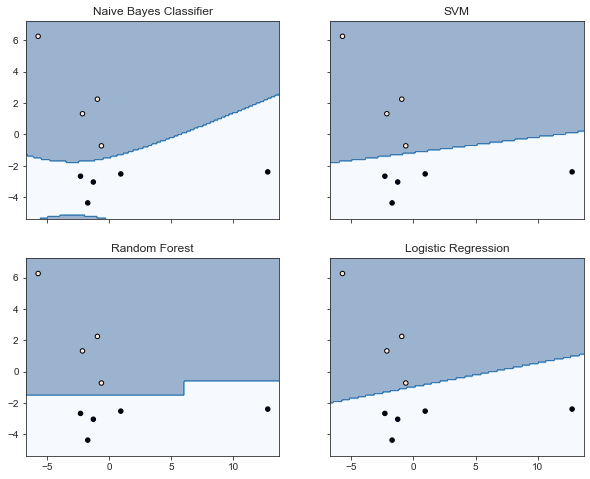

In [278]:
reduced_data = X_reduced

trainednb = GaussianNB().fit(reduced_data, Y_Train)
trainedsvm = svm.LinearSVC().fit(reduced_data, Y_Train)
trainedforest = RandomForestClassifier(n_estimators=700).fit(reduced_data,Y_Train)
trainedmodel = LogisticRegression().fit(reduced_data,Y_Train)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [trainednb, trainedsvm, trainedforest, trainedmodel],
                        ['Naive Bayes Classifier', 'SVM',
                         'Random Forest', 'Logistic Regression']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, cmap=plt.cm.Blues, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(reduced_data[:, 0], reduced_data[:, 1], c=Y_Train,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

### Linear Discriminant Analysis

In [128]:
# Load libraries
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create an LDA that will reduce the data down to 1 feature
lda = LinearDiscriminantAnalysis(n_components=1)

# run an LDA and use it to transform the features
X_lda = lda.fit(X, Y).transform(X)

# Print the number of features
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_lda.shape[1])

## View the ratio of explained variance
print(lda.explained_variance_ratio_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(X_lda, Y, test_size = 0.30, random_state = 101)

trainednb = GaussianNB().fit(X_reduced, Y_Train)
trainedsvm = svm.LinearSVC().fit(X_reduced, Y_Train)

print('Naive Bayes')
predictionnb = trainednb.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

print('SVM')
predictionsvm = trainedsvm.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

Original number of features: 74
Reduced number of features: 1
[1.]
Naive Bayes
[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

SVM
[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### t-SNE

In [129]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 12 nearest neighbors...
[t-SNE] Indexed 13 samples in 0.000s...
[t-SNE] Computed neighbors for 13 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 13 / 13
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.147190
[t-SNE] KL divergence after 300 iterations: 0.408108
t-SNE done! Time elapsed: 0.5413088798522949 seconds


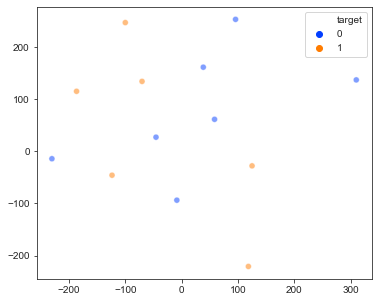

In [267]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x = tsne_results[:,0], y=tsne_results[:,1],
    hue = Y,
    palette = sns.color_palette("bright", 2),
    data = df_audio,
    legend = "full",
    alpha = 0.5
)

## Clustering

In [279]:
pca = PCA(n_components=2,svd_solver='full')
X_pca = pca.fit_transform(X)

print('PCA Explained Variance: ', pca.explained_variance_)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_lda.shape[1])
print('PCA Explained Variance Ratio: ', pca.explained_variance_ratio_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(X_pca, Y, test_size = 0.30, random_state = 101)

PCA Explained Variance:  [22.79265882 13.50943425]
Original number of features: 74
Reduced number of features: 1
PCA Explained Variance Ratio:  [0.28431591 0.16851685]


### K-Means

In [280]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_reduced)
kpredictions = kmeans.predict(X_test_reduced)
print(confusion_matrix(Y_Test,kpredictions))
print(classification_report(Y_Test,kpredictions))

[[2 0]
 [2 0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


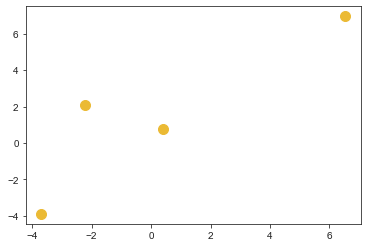

In [281]:
plt.scatter(X_test_reduced[kpredictions ==0,0], X_test_reduced[kpredictions == 0,1], s=100, c='#ebba34')
plt.scatter(X_test_reduced[kpredictions ==1,0], X_test_reduced[kpredictions == 1,1], s=100, c='#000000')

### Hierarchical Clustering

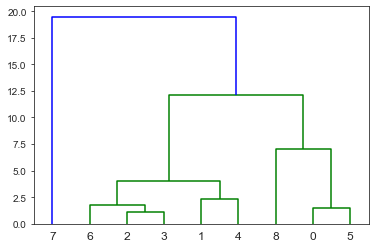

In [282]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(X_reduced, method='ward'))

# create clusters
hc = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart
hierarchicalpredictions = hc.fit_predict(X_test_reduced)

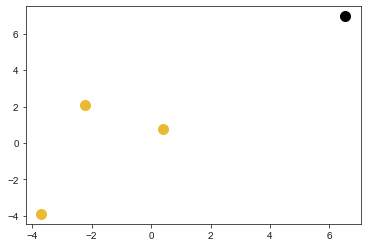

In [283]:
plt.scatter(X_test_reduced[hierarchicalpredictions ==0,0], X_test_reduced[hierarchicalpredictions == 0,1], s=100, c='#ebba34')
plt.scatter(X_test_reduced[hierarchicalpredictions ==1,0], X_test_reduced[hierarchicalpredictions == 1,1], s=100, c='#000000')

### Deep Learning

In [136]:
from keras.utils.np_utils import to_categorical
Y_Train = to_categorical(Y_Train)

Using TensorFlow backend.


In [137]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, BatchNormalization, Activation

#Y_Test = to_categorical(Y_Test)

input_dim = X_Train.shape[1]
nb_classes = Y_Train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(512, input_dim=input_dim))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

print("Training...")
model.fit(X_Train, Y_Train, nb_epoch=50, batch_size=16, validation_split=0.1, verbose=80)

preds = model.predict_classes(X_Test, verbose=0)

Training...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8 samples, validate on 1 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [138]:
print(confusion_matrix(Y_Test,preds))
print(classification_report(Y_Test,preds))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

